## Table Of Contents
<font size=3rem>
    
0 -**[ GPU SETTINGS](#GPU-SETTINGS)**<br>
1 -**[ BUSINESS UNDERSTANDING](#BUSINESS-UNDERSTANDING)**<br>
2 -**[ DATA UNDERSTANDING](#DATA-UNDERSTANDING)**<br>
3 -**[ DATA PREPARATION](#DATA-PREPARATION)**<br>
4 -**[ MODELING](#MODELING)**<br>
5 -**[ EVALUATION](#EVALUATION)<br>**
</font>
___

# BUSINESS UNDERSTANDING

- Student: Cody Freese
- Pace: Self Paced
- Jeff Herman

- Determine the difference between optical illusions and reality based images.

## Import Tools

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten
import cv2
import random
import datetime
from tensorflow.python.client import device_lib
from tensorflow.keras.applications.densenet import DenseNet201

Using TensorFlow backend.


In [2]:
notebook_original_start = datetime.datetime.now()

# GPU SETTINGS

In [3]:
# https://github.com/jeffheaton/present/blob/master/youtube/gpu/keras-dual-gpu.ipynb
# https://www.youtube.com/watch?v=HCLmM1PyDIs

# List of Local Devices
devices = device_lib.list_local_devices()

# Calculate size of device
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

# Data in Devices, Type, Name, Abrv, Memory
for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:GPU:0 ||  NVIDIA GeForce RTX 2070 SUPER || GPU || 5.8 GiB


In [4]:
print("Number of GPU's Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Number of GPU's Available:  1


## FUNCTIONS

In [5]:
def get_num_pixels(pixel_path):
    '''
    Gets width and height of image
    :param pixel_path: String
    :return width, height: Tuple of Int
    '''
    
    width, height = Image.open(pixel_path).size
    return width, height

In [6]:
def get_image_pixels_and_paths(path):
    '''
    Joins the classes of called picture pixel count for total of called class
    :param path: String
    :return None: prints out pixel dimensions
    '''
    
    # Iterate through 5 entries to print number of pixels from image
    for path, subdirs, files in os.walk(path):
        for index, name in enumerate(files):
            image_path = os.path.join(path,name)
            print(get_num_pixels(image_path))
            if index >= 4:
                break

In [7]:
# Code Sourced from Learn.Co, modified for this project
# https://github.com/learn-co-curriculum/dsc-image-classification-with-mlps-lab/tree/solution
def visualize_training_results(results):
    '''
    Renders out metric results into graphs
    :param results: tensorflow.python.keras.callbacks.History
    :return None: print out graphs
    '''
    # Assign variable for model history results
    history = results.history
    
    # Loss metric
    plt.figure()
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['loss','val_loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    # Accuracy metric
    plt.figure()
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.legend(['accuracy','val_accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    # Precision metric
    plt.figure()
    plt.plot(history['precision'])
    plt.plot(history['val_precision'])
    plt.legend(['precision','val_precision'])
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.show()
    
    # Recall metric
    plt.figure()
    plt.plot(history['recall'])
    plt.plot(history['val_recall'])
    plt.legend(['recall','val_recall'])
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()

 # DATA UNDERSTANDING

In [8]:
#Home Directory
home_path = r'C:\Users\c_fre\Learn.co\Module_5_Project\Illusion-Image-Classification\Images Ready for Model'

#Train Directory
train_path = os.path.join(home_path,'train')

#Validation Directory
val_path = os.path.join(home_path,'val')

#Test Directory
test_path = os.path.join(home_path,'test')

#Train Subdirectories
normal_train_path = os.path.join(train_path,'NORMAL')

autostereogram_train_path = os.path.join(train_path,'AUTOSTEREOGRAM')

#Validation Subdirectories
normal_val_path = os.path.join(val_path,'NORMAL')

autostereogram_val_path = os.path.join(val_path,'AUTOSTEREOGRAM')

#Test Subdirectories

normal_test_path = os.path.join(test_path,'NORMAL')

autostereogram_test_path = os.path.join(test_path,'AUTOSTEREOGRAM')

In [9]:
#Print to Verify Directory Pathways
print('Directory Contents:',os.listdir(home_path))
print('train Contents:',os.listdir(train_path))
print('val Contents:',os.listdir(val_path))
print('test Contents:',os.listdir(test_path))

Directory Contents: ['test', 'train', 'val']
train Contents: ['AUTOSTEREOGRAM', 'NORMAL']
val Contents: ['AUTOSTEREOGRAM', 'NORMAL']
test Contents: ['AUTOSTEREOGRAM', 'NORMAL']


In [10]:
#Cases in Training Sets
print("Number of cases in Training:",len(os.listdir(normal_train_path)) +len(os.listdir(autostereogram_train_path)))

#Pneumonia Cases in Training
print("Number of Autostereogram cases in Training:",len(os.listdir(autostereogram_train_path)))

#Normal Cases in Training
print("Number of Normal cases in Training:",len(os.listdir(normal_train_path)))

Number of cases in Training: 1370
Number of Autostereogram cases in Training: 700
Number of Normal cases in Training: 670


In [11]:
# Cases in Validation Sets
print("Number of cases in Validation:",len(os.listdir(normal_val_path)) +len(os.listdir(autostereogram_val_path)))

# Pneumonia Cases in Validation
print("Number of Autostereogram cases in Validation:",len(os.listdir(autostereogram_val_path)))

# Normal Cases in Validation
print("Number of Normal cases in Validation:",len(os.listdir(normal_val_path)))

Number of cases in Validation: 315
Number of Autostereogram cases in Validation: 150
Number of Normal cases in Validation: 165


In [12]:
#Cases in Test Sets
print("Number of cases in Test:",len(os.listdir(normal_test_path)) +len(os.listdir(autostereogram_test_path)))

#Autostereogram Cases in Test
print("Number of Autostereogram cases in Test:",len(os.listdir(autostereogram_test_path)))

#Normal cases in Test
print("Number of Normal cases in Test:",len(os.listdir(normal_test_path)))

Number of cases in Test: 315
Number of Autostereogram cases in Test: 150
Number of Normal cases in Test: 165


In [13]:
# #Total number of Normal Cases
print("Total number of Normal cases:",
      len(os.listdir(normal_test_path))+
      len(os.listdir(normal_train_path))+
      len(os.listdir(normal_val_path)))

#Total number of Autostereogram Cases
print("Total number of Autostereogram cases:",
      len(os.listdir(autostereogram_test_path))+
      len(os.listdir(autostereogram_train_path))+
      len(os.listdir(autostereogram_val_path)))

Total number of Normal cases: 1000
Total number of Autostereogram cases: 1000


In [14]:
# Validation Pixel Size
get_image_pixels_and_paths(val_path)

(671, 537)
(800, 600)
(800, 600)
(800, 600)
(800, 600)
(400, 400)
(225, 225)
(213, 237)
(208, 242)
(176, 286)


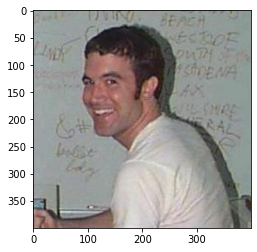

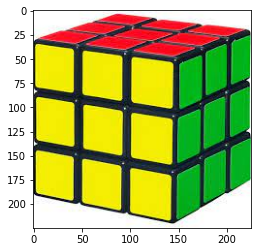

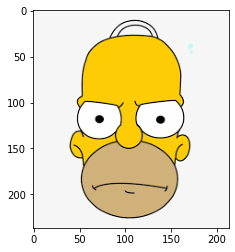

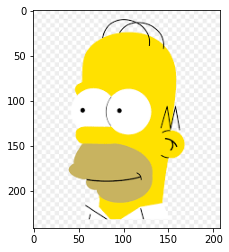

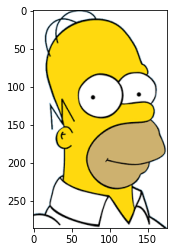

In [15]:
# Display all images in Normal Validatoin pathway
normal_val_images_display = os.listdir(normal_val_path)[:5]
for image_name in normal_val_images_display:
    image_path = os.path.join(normal_val_path, image_name)
    img = image.load_img(image_path)
    plt.imshow(img)
    plt.show()

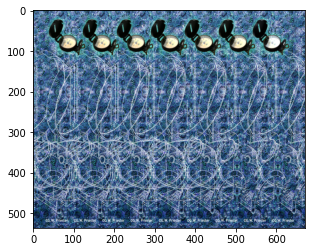

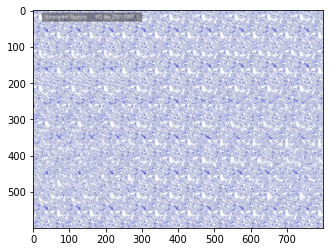

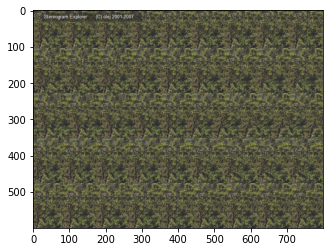

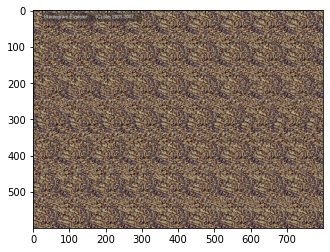

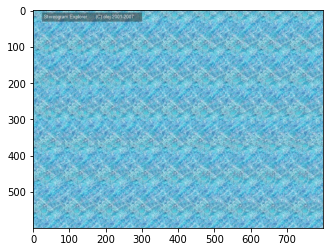

In [16]:
# Display all images in Pneumonia validation pathway
autostereogram_val_image_display = os.listdir(autostereogram_val_path)[:5]
for image_name in autostereogram_val_image_display:
    image_path = os.path.join(autostereogram_val_path, image_name)
    img = image.load_img(image_path)
    plt.imshow(img)
    plt.show()

# DATA PREPARATION

In [17]:
# Double default batch size due to computer hardware
batch_size = 64

# Set all image sizes universally
img_width, img_height = 200,200

In [18]:
# Augmentation of Training data, rescale
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest")


# Rescale validation data
val_datagen = ImageDataGenerator(rescale=1 / 255.0)

# Rescale test data
test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [19]:
# Training Generator
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(img_width, img_height),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    seed=7539541
)

# Validation Generator
valid_generator = val_datagen.flow_from_directory(
    directory=val_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    seed=7539541
)

# Test Generator
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(img_width, img_height),
    color_mode="rgb",
    batch_size=64,
    class_mode="binary",
    shuffle=True,
    seed=7539541
)

Found 1370 images belonging to 2 classes.
Found 315 images belonging to 2 classes.
Found 315 images belonging to 2 classes.


# MODELING

## Multi Layer Perceptron

In [20]:
# Start time of model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [21]:
# Sequential: as we want to build layers upon each other
mlp_model = keras.Sequential()

In [22]:
# Fuse paths without losing scalability
mlp_model.add(keras.layers.Flatten())

In [23]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
mlp_model.add(keras.layers.Dense(64,
                                 activation='relu'))

In [24]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
mlp_model.add(keras.layers.Dense(32,
                                 activation='relu'))

In [25]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
mlp_model.add(keras.layers.Dense(16,
                                 activation='relu'))

In [26]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
mlp_model.add(keras.layers.Dense(8,
                                 activation='relu'))

In [27]:
# Full input, Binary output with sigmoid
mlp_model.add(keras.layers.Dense(1,
                                 activation='sigmoid'))

In [28]:
# Compile. Binary Crossentropy to Predict Probability to actual class output, Stochastic Gradient Descent via Adam
mlp_model.compile(loss="binary_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])

In [29]:
# Fit Model, 10 Epochs
mlp_history = mlp_model.fit(train_generator,
                            validation_data = valid_generator,
                            steps_per_epoch = train_generator.n//train_generator.batch_size,
                            validation_steps = valid_generator.n//valid_generator.batch_size,
                            epochs=10)

# Stop time of model
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/10
10/21 [=============>................] - ETA: 9s - loss: 2.5924 - accuracy: 0.5000 - precision: 0.5035 - recall: 0.6656 

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 22s 1s/step - loss: 1.8189 - accuracy: 0.5107 - precision: 0.5032 - recall: 0.6025 - val_loss: 0.7154 - val_accuracy: 0.6445 - val_precision: 0.7157 - val_recall: 0.5407
Epoch 2/10
21/21 [==============================] - 16s 752ms/step - loss: 1.0198 - accuracy: 0.5636 - precision: 0.5496 - recall: 0.5909 - val_loss: 0.5883 - val_accuracy: 0.6250 - val_precision: 0.5990 - val_recall: 0.8582
Epoch 3/10
21/21 [==============================] - 16s 768ms/step - loss: 0.6719 - accuracy: 0.6103 - precision: 0.5950 - recall: 0.6369 - val_loss: 0.7104 - val_accuracy: 0.6289 - val_precision: 0.8600 - val_recall: 0.3282
Epoch 4/10
21/21 [==============================] - 16s 787ms/step - loss: 0.6291 - accuracy: 0.6585 - precision: 0.6304 - recall: 0.7141 - val_loss: 0.7765 - val_accuracy: 0.6406 - val_precision: 0.9787 - val_recall: 0.3358
Epoch 5/10
21/21 [==============================] - 16s 767ms/step - loss: 0.7311 - accuracy: 0.6409 - precision: 

In [30]:
# Save Model Locally
mlp_model.save("MLP_Initial_Model")

INFO:tensorflow:Assets written to: MLP_Initial_Model\assets


In [31]:
# Summary of Model
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, None)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                7680064   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 7,682,817
Trainable params: 7,682,817
Non-trainable params: 0
______________________________________________

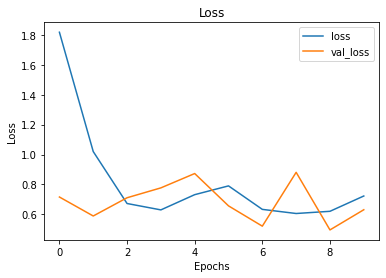

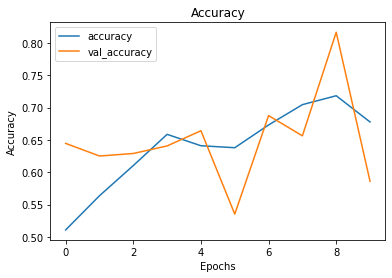

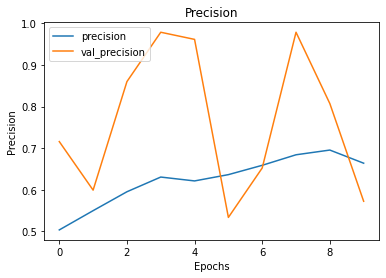

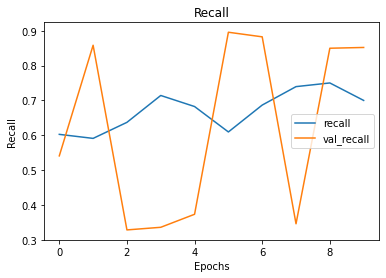

In [32]:
# Visualize Model Metrics
visualize_training_results(mlp_history)

In [33]:
# Evaluate against Training set
mlp_results_train = mlp_model.evaluate(train_generator)

14/22 [==================>...........] - ETA: 5s - loss: 0.6789 - accuracy: 0.6272 - precision: 0.5889 - recall: 0.8149

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


22/22 [==============================] - 15s 675ms/step - loss: 0.6727 - accuracy: 0.6241 - precision: 0.5822 - recall: 0.8194


In [34]:
# Evaluate against Test set
mlp_results_test = mlp_model.evaluate(test_generator)

5/5 [==============================] - 3s 659ms/step - loss: 0.6769 - accuracy: 0.6317 - precision: 0.6099 - recall: 0.8242


## CNN Model

In [35]:
# Start time of model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [36]:
# Sequential: as we want to build layers upon each other
cnn_model = keras.Sequential()

In [37]:
# 2D Convolution Layer over Images, Generate 64 filters and multiply across the image
# Filter Images to highlight features
cnn_model.add(keras.layers.Conv2D(64,
                                  kernel_size=(3,3),
                                  activation='relu',
                                  input_shape=(img_width, img_height, 3)))

In [38]:
# Group images into 2x2, votes on largest, features maintained
cnn_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

In [39]:
# Fuse paths without losing scalability
cnn_model.add(keras.layers.Flatten())

In [40]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
cnn_model.add(keras.layers.Dense(64,
                                 activation='relu'))

In [41]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
cnn_model.add(keras.layers.Dense(32,
                                 activation='relu'))

In [42]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
cnn_model.add(keras.layers.Dense(16,
                                 activation='relu'))

In [43]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
cnn_model.add(keras.layers.Dense(8,
                                 activation='relu'))

In [44]:
# Full input, Binary output with sigmoid
cnn_model.add(keras.layers.Dense(1,
                                 activation='sigmoid'))

In [45]:
# Compile. Binary Crossentropy to Predict Probability to actual class output, Stochastic Gradient Descent via Adam
cnn_model.compile(loss="binary_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])

In [46]:
# Summary of Model
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 627264)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                40144960  
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                

In [47]:
# Fit Model, 10 Epochs
cnn_history = cnn_model.fit(train_generator,
                        validation_data = valid_generator,
                        steps_per_epoch = train_generator.n//train_generator.batch_size,
                        validation_steps = valid_generator.n//valid_generator.batch_size,
                        epochs=10)

# Stop time of model
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/10
21/21 [==============================] - 20s 752ms/step - loss: 1.9169 - accuracy: 0.6776 - precision: 0.6628 - recall: 0.7070 - val_loss: 0.3778 - val_accuracy: 0.8633 - val_precision: 1.0000 - val_recall: 0.7426
Epoch 2/10
21/21 [==============================] - 16s 772ms/step - loss: 0.2949 - accuracy: 0.8790 - precision: 0.8855 - recall: 0.8632 - val_loss: 0.4029 - val_accuracy: 0.8477 - val_precision: 0.9811 - val_recall: 0.7376
Epoch 3/10
21/21 [==============================] - 16s 769ms/step - loss: 0.2125 - accuracy: 0.9119 - precision: 0.9121 - recall: 0.9078 - val_loss: 0.2503 - val_accuracy: 0.9336 - val_precision: 0.9844 - val_recall: 0.8936
Epoch 4/10
21/21 [==============================] - 16s 769ms/step - loss: 0.1786 - accuracy: 0.9372 - precision: 0.9371 - recall: 0.9342 - val_loss: 0.2161 - val_accuracy: 0.9492 - val_precision: 0.9677 - val_recall: 0.9302
Epoch 5/10
21/21 [==============================] - 16s 773ms/step - loss: 0.1913 - accuracy: 0.9334

In [48]:
# Save model locally
cnn_model.save("CNN_Initial_Model")

INFO:tensorflow:Assets written to: CNN_Initial_Model\assets


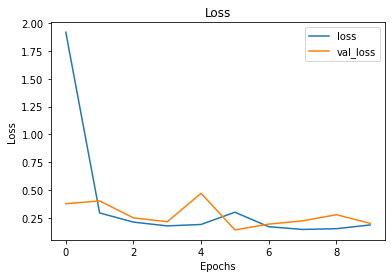

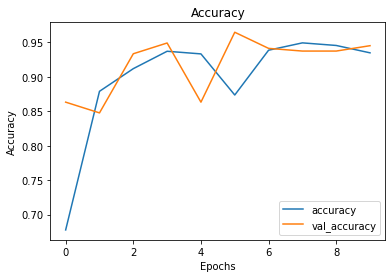

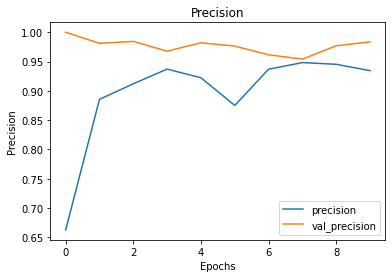

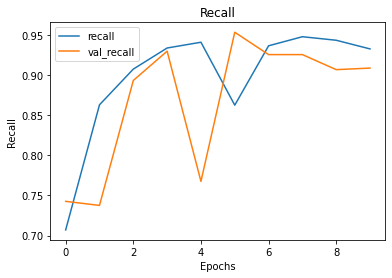

In [49]:
# Visualize Model Metrics
visualize_training_results(cnn_history)

In [50]:
# Evaluate against Training set
cnn_results_train = cnn_model.evaluate(train_generator)
cnn_results_train

 1/22 [>.............................] - ETA: 15s - loss: 0.1110 - accuracy: 0.9844 - precision: 1.0000 - recall: 0.9688

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


22/22 [==============================] - 15s 673ms/step - loss: 0.1401 - accuracy: 0.9511 - precision: 0.9480 - recall: 0.9522


[0.14014901220798492, 0.9510948657989502, 0.9479940533638, 0.9522387981414795]

In [51]:
# Evaluate against Test set
cnn_results_test = cnn_model.evaluate(test_generator)
cnn_results_test

5/5 [==============================] - 2s 465ms/step - loss: 0.2805 - accuracy: 0.9270 - precision: 0.9329 - recall: 0.9273


[0.28049784898757935,
 0.9269841313362122,
 0.9329268336296082,
 0.9272727370262146]

## Finetune Models

### MLP Finetune

In [52]:
# Start time of model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [53]:
# Checkpoint, Monitor Loss, Save best results
mlp_checkpoint = tf.keras.callbacks.ModelCheckpoint("MLP_Finetune_Checkpoint",
                                                monitor="val_loss",
                                                save_best_only=True)

# Early stop after 10 efforts to learn, each Epoch starts with best saved weights
mlp_early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  monitor="val_loss",
                                                  restore_best_weights=True)

In [54]:
# Fit Model, 100 Epochs, Checkpoint and Early Stop
mlp_finetune_history = mlp_model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    epochs=100,
    validation_data=valid_generator,
    validation_steps = valid_generator.n//valid_generator.batch_size,
    callbacks=[mlp_checkpoint, mlp_early_stopping]
)

# Stop time of model
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/100
21/21 [==============================] - 16s 769ms/step - loss: 0.5563 - accuracy: 0.7619 - precision: 0.7841 - recall: 0.7094 - val_loss: 0.4555 - val_accuracy: 0.8359 - val_precision: 0.8041 - val_recall: 0.9015
INFO:tensorflow:Assets written to: MLP_Finetune_Checkpoint\assets
Epoch 2/100
 3/21 [===>..........................] - ETA: 12s - loss: 0.4609 - accuracy: 0.7969 - precision: 0.7570 - recall: 0.8617

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 16s 768ms/step - loss: 0.5001 - accuracy: 0.7596 - precision: 0.7611 - recall: 0.7445 - val_loss: 0.4477 - val_accuracy: 0.8398 - val_precision: 0.8537 - val_recall: 0.8203
INFO:tensorflow:Assets written to: MLP_Finetune_Checkpoint\assets
Epoch 3/100
19/21 [==========================>...] - ETA: 1s - loss: 0.4314 - accuracy: 0.8294 - precision: 0.8412 - recall: 0.8017

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 16s 759ms/step - loss: 0.4267 - accuracy: 0.8354 - precision: 0.8493 - recall: 0.8053 - val_loss: 0.4527 - val_accuracy: 0.8164 - val_precision: 0.9400 - val_recall: 0.6963
Epoch 4/100
21/21 [==============================] - 16s 762ms/step - loss: 0.4342 - accuracy: 0.8346 - precision: 0.8625 - recall: 0.7900 - val_loss: 0.3922 - val_accuracy: 0.8750 - val_precision: 0.9068 - val_recall: 0.8359
INFO:tensorflow:Assets written to: MLP_Finetune_Checkpoint\assets
Epoch 5/100


C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 16s 780ms/step - loss: 0.4102 - accuracy: 0.8467 - precision: 0.8754 - recall: 0.8009 - val_loss: 0.4836 - val_accuracy: 0.8086 - val_precision: 0.7857 - val_recall: 0.8832
Epoch 6/100
21/21 [==============================] - 16s 760ms/step - loss: 0.5444 - accuracy: 0.7504 - precision: 0.7282 - recall: 0.7828 - val_loss: 0.3979 - val_accuracy: 0.8594 - val_precision: 0.9545 - val_recall: 0.7721
Epoch 7/100
21/21 [==============================] - 16s 758ms/step - loss: 0.4062 - accuracy: 0.8415 - precision: 0.8651 - recall: 0.8016 - val_loss: 0.4203 - val_accuracy: 0.8555 - val_precision: 0.9000 - val_recall: 0.8120
Epoch 8/100
21/21 [==============================] - 16s 761ms/step - loss: 0.3889 - accuracy: 0.8606 - precision: 0.8851 - recall: 0.8213 - val_loss: 0.4205 - val_accuracy: 0.8594 - val_precision: 0.9055 - val_recall: 0.8273
Epoch 9/100
21/21 [==============================] - 16s 763ms/step - loss: 0.4071 - accuracy: 0.8361 - prec

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 16s 770ms/step - loss: 0.3788 - accuracy: 0.8560 - precision: 0.8832 - recall: 0.8107 - val_loss: 0.5017 - val_accuracy: 0.7422 - val_precision: 0.6994 - val_recall: 0.8963
Epoch 15/100
21/21 [==============================] - 16s 772ms/step - loss: 0.3722 - accuracy: 0.8407 - precision: 0.8536 - recall: 0.8135 - val_loss: 0.3269 - val_accuracy: 0.8750 - val_precision: 0.9262 - val_recall: 0.8309
INFO:tensorflow:Assets written to: MLP_Finetune_Checkpoint\assets
Epoch 16/100
 1/21 [>.............................] - ETA: 15s - loss: 0.2165 - accuracy: 0.9219 - precision: 0.9310 - recall: 0.9000

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 16s 762ms/step - loss: 0.3672 - accuracy: 0.8752 - precision: 0.8985 - recall: 0.8411 - val_loss: 0.4481 - val_accuracy: 0.8516 - val_precision: 0.9123 - val_recall: 0.7879
Epoch 17/100
21/21 [==============================] - 16s 771ms/step - loss: 0.3379 - accuracy: 0.8867 - precision: 0.9273 - recall: 0.8349 - val_loss: 0.4053 - val_accuracy: 0.8633 - val_precision: 0.9459 - val_recall: 0.7836
Epoch 18/100
21/21 [==============================] - 16s 764ms/step - loss: 0.3388 - accuracy: 0.8744 - precision: 0.8924 - recall: 0.8448 - val_loss: 0.3892 - val_accuracy: 0.8750 - val_precision: 0.8923 - val_recall: 0.8657
Epoch 19/100
21/21 [==============================] - 16s 765ms/step - loss: 0.3421 - accuracy: 0.8744 - precision: 0.8926 - recall: 0.8418 - val_loss: 0.4838 - val_accuracy: 0.8320 - val_precision: 0.9429 - val_recall: 0.7279
Epoch 20/100
21/21 [==============================] - 16s 761ms/step - loss: 0.2841 - accuracy: 0.9035 - 

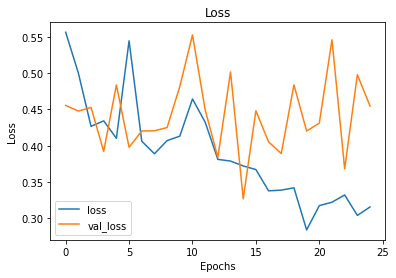

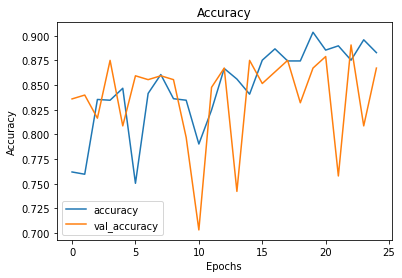

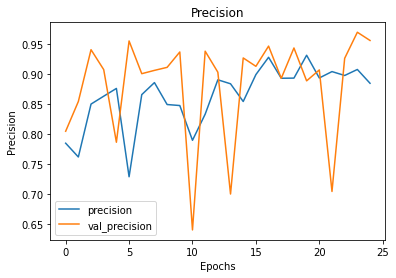

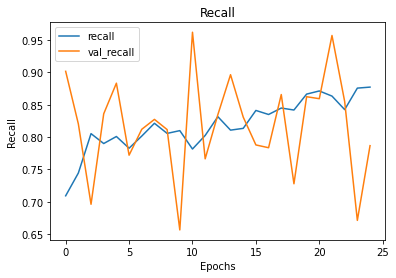

In [55]:
# Visualize Model Metrics
visualize_training_results(mlp_finetune_history)

In [56]:
# Evaluate model against Training set
mlp_results_train = mlp_model.evaluate(train_generator)

22/22 [==============================] - 15s 673ms/step - loss: 0.3188 - accuracy: 0.8759 - precision: 0.9340 - recall: 0.8030


In [57]:
# Evaluate model again Test set
mlp_results_test = mlp_model.evaluate(test_generator)

5/5 [==============================] - 2s 471ms/step - loss: 0.4585 - accuracy: 0.8000 - precision: 0.8148 - recall: 0.8000


### CNN Finetune

In [58]:
# Start time of model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [59]:
# Checkpoint, Monitor Loss, Save best results
cnn_checkpoint = tf.keras.callbacks.ModelCheckpoint("CNN_Finetune_Checkpoint",
                                                monitor="loss",
                                                save_best_only=True)

# Early stop after 10 efforts to learn, each Epoch starts with best saved weights
cnn_early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  monitor="loss",
                                                  restore_best_weights=True)

In [60]:
# Fit Model, 100 Epochs, Checkpoint and Early Stop
cnn_finetune_history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    epochs=100,
    validation_data=valid_generator,
    validation_steps = valid_generator.n//valid_generator.batch_size,
    callbacks=[cnn_checkpoint, cnn_early_stopping]
)

# Stop time of model
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/100
21/21 [==============================] - 16s 779ms/step - loss: 0.1393 - accuracy: 0.9456 - precision: 0.9384 - recall: 0.9516 - val_loss: 0.2544 - val_accuracy: 0.9453 - val_precision: 0.9832 - val_recall: 0.9070
INFO:tensorflow:Assets written to: CNN_Finetune_Checkpoint\assets
Epoch 2/100
 8/21 [==========>...................] - ETA: 9s - loss: 0.1069 - accuracy: 0.9599 - precision: 0.9602 - recall: 0.9559 

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 16s 788ms/step - loss: 0.1191 - accuracy: 0.9533 - precision: 0.9560 - recall: 0.9485 - val_loss: 0.2557 - val_accuracy: 0.9414 - val_precision: 0.9760 - val_recall: 0.9104
INFO:tensorflow:Assets written to: CNN_Finetune_Checkpoint\assets
Epoch 3/100
 5/21 [======>.......................] - ETA: 10s - loss: 0.1115 - accuracy: 0.9688 - precision: 0.9557 - recall: 0.9805

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 16s 762ms/step - loss: 0.1217 - accuracy: 0.9609 - precision: 0.9548 - recall: 0.9654 - val_loss: 0.1815 - val_accuracy: 0.9570 - val_precision: 0.9754 - val_recall: 0.9370
Epoch 4/100
21/21 [==============================] - 16s 785ms/step - loss: 0.1501 - accuracy: 0.9426 - precision: 0.9418 - recall: 0.9403 - val_loss: 0.2201 - val_accuracy: 0.9531 - val_precision: 0.9758 - val_recall: 0.9308
Epoch 5/100
21/21 [==============================] - 16s 760ms/step - loss: 0.1344 - accuracy: 0.9533 - precision: 0.9458 - recall: 0.9592 - val_loss: 0.2242 - val_accuracy: 0.9570 - val_precision: 0.9919 - val_recall: 0.9248
Epoch 6/100
21/21 [==============================] - 16s 758ms/step - loss: 0.1270 - accuracy: 0.9556 - precision: 0.9632 - recall: 0.9451 - val_loss: 0.1654 - val_accuracy: 0.9609 - val_precision: 0.9766 - val_recall: 0.9470
Epoch 7/100
21/21 [==============================] - 16s 763ms/step - loss: 0.1514 - accuracy: 0.9426 - prec

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 16s 771ms/step - loss: 0.0976 - accuracy: 0.9694 - precision: 0.9677 - recall: 0.9707 - val_loss: 0.2129 - val_accuracy: 0.9570 - val_precision: 0.9840 - val_recall: 0.9318
INFO:tensorflow:Assets written to: CNN_Finetune_Checkpoint\assets
Epoch 10/100


C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 16s 768ms/step - loss: 0.0945 - accuracy: 0.9701 - precision: 0.9687 - recall: 0.9702 - val_loss: 0.2669 - val_accuracy: 0.9453 - val_precision: 0.9756 - val_recall: 0.9160
INFO:tensorflow:Assets written to: CNN_Finetune_Checkpoint\assets
Epoch 11/100
 5/21 [======>.......................] - ETA: 10s - loss: 0.1164 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9603

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 16s 768ms/step - loss: 0.0934 - accuracy: 0.9648 - precision: 0.9608 - recall: 0.9669 - val_loss: 0.1833 - val_accuracy: 0.9609 - val_precision: 0.9783 - val_recall: 0.9507
INFO:tensorflow:Assets written to: CNN_Finetune_Checkpoint\assets
Epoch 12/100
 5/21 [======>.......................] - ETA: 10s - loss: 0.0625 - accuracy: 0.9750 - precision: 0.9762 - recall: 0.9762

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 16s 755ms/step - loss: 0.1254 - accuracy: 0.9556 - precision: 0.9485 - recall: 0.9605 - val_loss: 0.1355 - val_accuracy: 0.9648 - val_precision: 0.9766 - val_recall: 0.9542
Epoch 13/100
21/21 [==============================] - 16s 782ms/step - loss: 0.1649 - accuracy: 0.9390 - precision: 0.9320 - recall: 0.9434 - val_loss: 0.1965 - val_accuracy: 0.9531 - val_precision: 0.9771 - val_recall: 0.9343
Epoch 14/100
21/21 [==============================] - 16s 755ms/step - loss: 0.0951 - accuracy: 0.9671 - precision: 0.9670 - recall: 0.9655 - val_loss: 0.1203 - val_accuracy: 0.9688 - val_precision: 0.9771 - val_recall: 0.9624
Epoch 15/100
21/21 [==============================] - 16s 765ms/step - loss: 0.0848 - accuracy: 0.9671 - precision: 0.9658 - recall: 0.9673 - val_loss: 0.1577 - val_accuracy: 0.9688 - val_precision: 0.9847 - val_recall: 0.9556
INFO:tensorflow:Assets written to: CNN_Finetune_Checkpoint\assets
Epoch 16/100
 2/21 [=>.................

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 16s 766ms/step - loss: 0.0733 - accuracy: 0.9717 - precision: 0.9615 - recall: 0.9811 - val_loss: 0.2379 - val_accuracy: 0.9492 - val_precision: 0.9764 - val_recall: 0.9254
INFO:tensorflow:Assets written to: CNN_Finetune_Checkpoint\assets
Epoch 17/100
 6/21 [=======>......................] - ETA: 11s - loss: 0.0361 - accuracy: 0.9896 - precision: 0.9950 - recall: 0.9851

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 16s 776ms/step - loss: 0.0740 - accuracy: 0.9740 - precision: 0.9706 - recall: 0.9766 - val_loss: 0.1603 - val_accuracy: 0.9648 - val_precision: 0.9773 - val_recall: 0.9556
Epoch 18/100
21/21 [==============================] - 16s 776ms/step - loss: 0.0786 - accuracy: 0.9686 - precision: 0.9703 - recall: 0.9657 - val_loss: 0.1551 - val_accuracy: 0.9648 - val_precision: 0.9924 - val_recall: 0.9424
Epoch 19/100
21/21 [==============================] - 16s 771ms/step - loss: 0.0740 - accuracy: 0.9724 - precision: 0.9717 - recall: 0.9717 - val_loss: 0.1388 - val_accuracy: 0.9609 - val_precision: 0.9764 - val_recall: 0.9466
Epoch 20/100
21/21 [==============================] - 16s 771ms/step - loss: 0.0905 - accuracy: 0.9663 - precision: 0.9597 - recall: 0.9717 - val_loss: 0.2015 - val_accuracy: 0.9570 - val_precision: 0.9764 - val_recall: 0.9394
Epoch 21/100
21/21 [==============================] - 16s 770ms/step - loss: 0.0656 - accuracy: 0.9770 - 

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 16s 768ms/step - loss: 0.0677 - accuracy: 0.9763 - precision: 0.9720 - recall: 0.9797 - val_loss: 0.1753 - val_accuracy: 0.9609 - val_precision: 0.9762 - val_recall: 0.9462
Epoch 23/100
21/21 [==============================] - 16s 763ms/step - loss: 0.0497 - accuracy: 0.9855 - precision: 0.9815 - recall: 0.9891 - val_loss: 0.2688 - val_accuracy: 0.9375 - val_precision: 0.9744 - val_recall: 0.8976
INFO:tensorflow:Assets written to: CNN_Finetune_Checkpoint\assets
Epoch 24/100
19/21 [==========================>...] - ETA: 1s - loss: 0.0696 - accuracy: 0.9720 - precision: 0.9752 - recall: 0.9666

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 16s 768ms/step - loss: 0.0658 - accuracy: 0.9740 - precision: 0.9764 - recall: 0.9703 - val_loss: 0.1339 - val_accuracy: 0.9727 - val_precision: 0.9852 - val_recall: 0.9638
Epoch 25/100
21/21 [==============================] - 16s 774ms/step - loss: 0.0561 - accuracy: 0.9832 - precision: 0.9785 - recall: 0.9876 - val_loss: 0.1100 - val_accuracy: 0.9727 - val_precision: 0.9852 - val_recall: 0.9638
Epoch 26/100
21/21 [==============================] - 17s 787ms/step - loss: 0.0613 - accuracy: 0.9784 - precision: 0.9715 - recall: 0.9848 - val_loss: 0.2115 - val_accuracy: 0.9609 - val_precision: 0.9758 - val_recall: 0.9453
Epoch 27/100
21/21 [==============================] - 16s 776ms/step - loss: 0.0724 - accuracy: 0.9724 - precision: 0.9719 - recall: 0.9719 - val_loss: 0.2235 - val_accuracy: 0.9570 - val_precision: 0.9779 - val_recall: 0.9433
Epoch 28/100
21/21 [==============================] - 16s 789ms/step - loss: 0.0567 - accuracy: 0.9832 - 

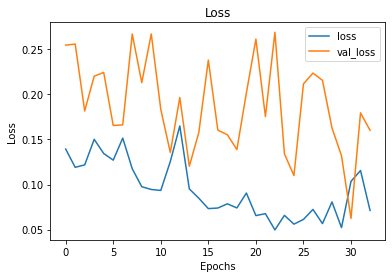

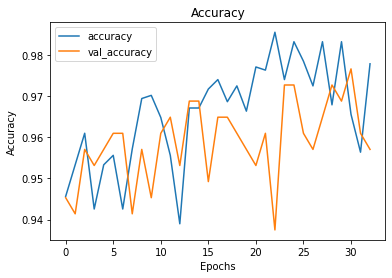

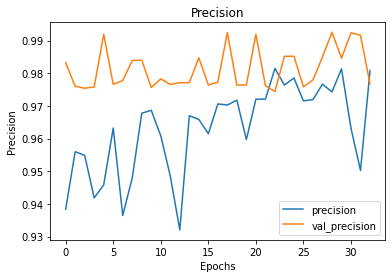

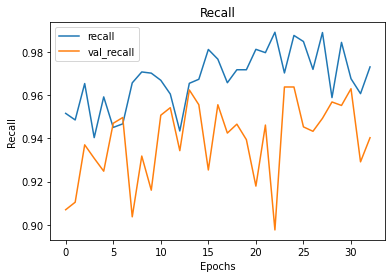

In [61]:
# Visualize Model Metrics
visualize_training_results(cnn_finetune_history)

In [62]:
# Evaluate against Training set
cnn_results_train = cnn_model.evaluate(train_generator)

22/22 [==============================] - 15s 688ms/step - loss: 0.0463 - accuracy: 0.9832 - precision: 0.9894 - recall: 0.9761


In [63]:
# Evaluate against Test set
cnn_results_test = cnn_model.evaluate(test_generator)

5/5 [==============================] - 2s 434ms/step - loss: 0.2811 - accuracy: 0.9397 - precision: 0.9620 - recall: 0.9212


## Pretrained Model

In [64]:
# Start time of model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [65]:
# Initialize Pretrain Base Model
pretrain_base = DenseNet201(weights=None,
                 include_top=False,
                 input_shape=(200, 200, 3))

# Define Model Architecture
pretrain_model = keras.Sequential()
pretrain_model.add(pretrain_base)
pretrain_model.add(keras.layers.Flatten())
pretrain_model.add(keras.layers.Dense(64, activation='relu'))
pretrain_model.add(keras.layers.Dense(128, activation='relu'))
pretrain_model.add(keras.layers.Dense(256, activation='relu'))
pretrain_model.add(keras.layers.Dense(128, activation='relu'))
pretrain_model.add(keras.layers.Dense(1, activation='sigmoid'))

# Do NOT train the base
pretrain_base.trainable = False

# Summary of Model
pretrain_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 6, 6, 1920)        18321984  
_________________________________________________________________
flatten_2 (Flatten)          (None, 69120)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4423744   
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_12 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

In [66]:
# Compile. Binary Crossentropy to Predict Probability to actual class output, Stochastic Gradient Descent via Adam
pretrain_model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy',
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall')])

In [67]:
# Fit Model, 10 Epochs
pretrain_model_history = pretrain_model.fit(train_generator,
                                            validation_data = valid_generator,
                                            steps_per_epoch = train_generator.n//train_generator.batch_size,
                                            validation_steps = valid_generator.n//valid_generator.batch_size,
                                            epochs=10)

# Stop time of model
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/10
21/21 [==============================] - 30s 998ms/step - loss: 0.6358 - accuracy: 0.6110 - precision: 0.5991 - recall: 0.6308 - val_loss: 0.4079 - val_accuracy: 0.8516 - val_precision: 0.9798 - val_recall: 0.7293
Epoch 2/10
21/21 [==============================] - 17s 795ms/step - loss: 0.3560 - accuracy: 0.8507 - precision: 0.8483 - recall: 0.8443 - val_loss: 0.1425 - val_accuracy: 0.9414 - val_precision: 0.9609 - val_recall: 0.9248
Epoch 3/10
21/21 [==============================] - 17s 804ms/step - loss: 0.2238 - accuracy: 0.9058 - precision: 0.8914 - recall: 0.9181 - val_loss: 0.1799 - val_accuracy: 0.9258 - val_precision: 0.8733 - val_recall: 1.0000
Epoch 4/10
21/21 [==============================] - 17s 806ms/step - loss: 0.1789 - accuracy: 0.9334 - precision: 0.9228 - recall: 0.9417 - val_loss: 0.1197 - val_accuracy: 0.9492 - val_precision: 0.9920 - val_recall: 0.9118
Epoch 5/10
21/21 [==============================] - 17s 800ms/step - loss: 0.2092 - accuracy: 0.9227

In [68]:
# Save model locally
pretrain_model.save("Pretrain_Initial_Model")

INFO:tensorflow:Assets written to: Pretrain_Initial_Model\assets


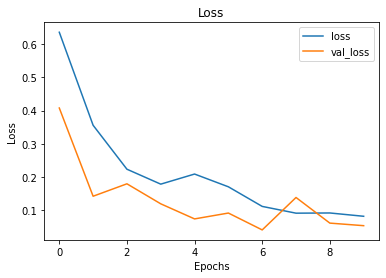

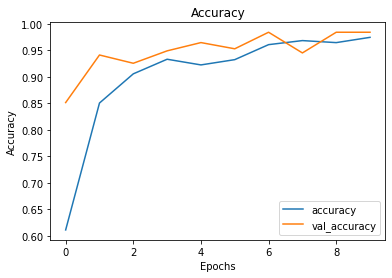

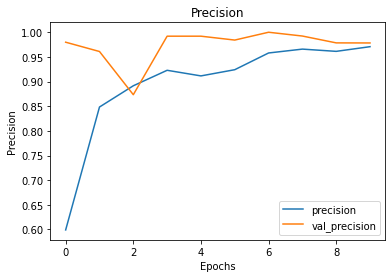

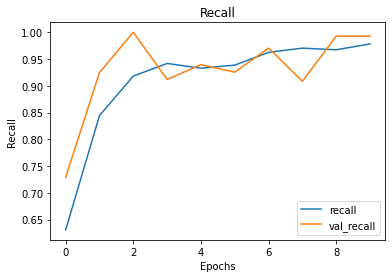

In [69]:
# Visualize Model Metrics
visualize_training_results(pretrain_model_history)

In [70]:
# Evaluate model against Training set
pretrain_results_train = pretrain_model.evaluate(train_generator)
pretrain_results_train

 5/22 [=====>........................] - ETA: 13s - loss: 0.0852 - accuracy: 0.9688 - precision: 0.9408 - recall: 0.9931

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


22/22 [==============================] - 16s 711ms/step - loss: 0.0869 - accuracy: 0.9693 - precision: 0.9473 - recall: 0.9925


[0.08690331876277924,
 0.9693430662155151,
 0.9472934603691101,
 0.9925373196601868]

In [71]:
# Evaluate model against Test set
pretrain_results_test = pretrain_model.evaluate(test_generator)
pretrain_results_test

5/5 [==============================] - 5s 1s/step - loss: 0.2691 - accuracy: 0.9302 - precision: 0.8865 - recall: 0.9939


[0.2690996825695038,
 0.9301587343215942,
 0.8864864706993103,
 0.9939393997192383]

## Finetune Pretrain

In [72]:
# Start time of model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [73]:
# Checkpoint, Monitor Loss, Save best results
pretrain_model_checkpoint = tf.keras.callbacks.ModelCheckpoint("Finetune_Pretrain_Checkpoint",
                                                               monitor="loss",
                                                               save_best_only=True)

# Early stop after 10 efforts to learn, each Epoch starts with best saved weights
pretrain_model_early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                                 monitor="loss",
                                                                 restore_best_weights=True)

In [74]:
# Initialize Pretrain Base Model
finetune_pretrain_base = DenseNet201(weights=None,
                                     include_top=False,
                                     input_shape=(200, 200, 3))

# Define Model Architecture
finetune_pretrain_base = keras.Sequential()
finetune_pretrain_base.add(pretrain_base)
finetune_pretrain_base.add(keras.layers.Flatten())
finetune_pretrain_base.add(keras.layers.Dense(64, activation='relu'))
finetune_pretrain_base.add(keras.layers.Dense(128, activation='relu'))
finetune_pretrain_base.add(keras.layers.Dense(256, activation='relu'))
finetune_pretrain_base.add(keras.layers.Dense(128, activation='relu'))
finetune_pretrain_base.add(keras.layers.Dense(1, activation='sigmoid'))

# Do NOT train the base
finetune_pretrain_base.trainable = False

# Summary of Model
finetune_pretrain_base.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 6, 6, 1920)        18321984  
_________________________________________________________________
flatten_3 (Flatten)          (None, 69120)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4423744   
_________________________________________________________________
dense_16 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_17 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

In [75]:
# Compile. Binary Crossentropy to Predict Probability to actual class output, Stochastic Gradient Descent via Adam
finetune_pretrain_base.compile(loss="binary_crossentropy",
                               optimizer="adam",
                               metrics=['accuracy',
                                        tf.keras.metrics.Precision(name='precision'),
                                        tf.keras.metrics.Recall(name='recall')])

In [76]:
# Fit Model, 100 Epochs, Checkpoint and Early Stop
finetune_pretrain_model_history = pretrain_model.fit(train_generator,
                                                     validation_data = valid_generator,
                                                     steps_per_epoch = train_generator.n//train_generator.batch_size,
                                                     validation_steps = valid_generator.n//valid_generator.batch_size,
                                                     callbacks=[pretrain_model_checkpoint, pretrain_model_early_stopping],
                                                     epochs=100)

# Stop time of model
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/100
21/21 [==============================] - 18s 857ms/step - loss: 0.0770 - accuracy: 0.9725 - precision: 0.9683 - recall: 0.9756 - val_loss: 0.1265 - val_accuracy: 0.9570 - val_precision: 0.9918 - val_recall: 0.9237
INFO:tensorflow:Assets written to: Finetune_Pretrain_Checkpoint\assets
Epoch 2/100
 2/21 [=>............................] - ETA: 14s - loss: 0.1144 - accuracy: 0.9609 - precision: 1.0000 - recall: 0.9206

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 18s 871ms/step - loss: 0.1006 - accuracy: 0.9658 - precision: 0.9636 - recall: 0.9665 - val_loss: 0.0643 - val_accuracy: 0.9844 - val_precision: 0.9926 - val_recall: 0.9783
Epoch 3/100
21/21 [==============================] - 18s 862ms/step - loss: 0.0764 - accuracy: 0.9740 - precision: 0.9704 - recall: 0.9765 - val_loss: 0.0726 - val_accuracy: 0.9727 - val_precision: 0.9781 - val_recall: 0.9710
INFO:tensorflow:Assets written to: Finetune_Pretrain_Checkpoint\assets
Epoch 4/100


C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 20s 928ms/step - loss: 0.0893 - accuracy: 0.9694 - precision: 0.9690 - recall: 0.9690 - val_loss: 0.0765 - val_accuracy: 0.9766 - val_precision: 0.9635 - val_recall: 0.9925
Epoch 5/100
21/21 [==============================] - 20s 940ms/step - loss: 0.1476 - accuracy: 0.9525 - precision: 0.9556 - recall: 0.9465 - val_loss: 0.0629 - val_accuracy: 0.9844 - val_precision: 0.9716 - val_recall: 1.0000
Epoch 6/100
21/21 [==============================] - 20s 939ms/step - loss: 0.1355 - accuracy: 0.9464 - precision: 0.9390 - recall: 0.9509 - val_loss: 0.2662 - val_accuracy: 0.9180 - val_precision: 0.9910 - val_recall: 0.8462
Epoch 7/100
21/21 [==============================] - 19s 923ms/step - loss: 0.1554 - accuracy: 0.9380 - precision: 0.9399 - recall: 0.9325 - val_loss: 0.0586 - val_accuracy: 0.9805 - val_precision: 0.9720 - val_recall: 0.9929
Epoch 8/100
21/21 [==============================] - 19s 915ms/step - loss: 0.0925 - accuracy: 0.9671 - prec

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 20s 948ms/step - loss: 0.1054 - accuracy: 0.9609 - precision: 0.9680 - recall: 0.9513 - val_loss: 0.0593 - val_accuracy: 0.9805 - val_precision: 0.9852 - val_recall: 0.9779
Epoch 11/100
21/21 [==============================] - 20s 952ms/step - loss: 0.1014 - accuracy: 0.9671 - precision: 0.9656 - recall: 0.9671 - val_loss: 0.0735 - val_accuracy: 0.9766 - val_precision: 0.9640 - val_recall: 0.9926
Epoch 12/100
21/21 [==============================] - 20s 955ms/step - loss: 0.0720 - accuracy: 0.9793 - precision: 0.9780 - recall: 0.9796 - val_loss: 0.0546 - val_accuracy: 0.9844 - val_precision: 0.9851 - val_recall: 0.9851
Epoch 13/100
21/21 [==============================] - 20s 967ms/step - loss: 0.0643 - accuracy: 0.9755 - precision: 0.9707 - recall: 0.9798 - val_loss: 0.0841 - val_accuracy: 0.9766 - val_precision: 0.9843 - val_recall: 0.9690
INFO:tensorflow:Assets written to: Finetune_Pretrain_Checkpoint\assets
Epoch 14/100
11/21 [==============

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 21s 1s/step - loss: 0.1008 - accuracy: 0.9648 - precision: 0.9638 - recall: 0.9638 - val_loss: 0.0743 - val_accuracy: 0.9727 - val_precision: 0.9762 - val_recall: 0.9685
Epoch 15/100
21/21 [==============================] - 22s 1s/step - loss: 0.0552 - accuracy: 0.9839 - precision: 0.9783 - recall: 0.9890 - val_loss: 0.0720 - val_accuracy: 0.9805 - val_precision: 0.9858 - val_recall: 0.9789
INFO:tensorflow:Assets written to: Finetune_Pretrain_Checkpoint\assets
Epoch 16/100
 6/21 [=======>......................] - ETA: 12s - loss: 0.0515 - accuracy: 0.9818 - precision: 0.9741 - recall: 0.9895

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 20s 969ms/step - loss: 0.0601 - accuracy: 0.9778 - precision: 0.9767 - recall: 0.9782 - val_loss: 0.0935 - val_accuracy: 0.9766 - val_precision: 0.9924 - val_recall: 0.9632
Epoch 17/100
21/21 [==============================] - 20s 960ms/step - loss: 0.0551 - accuracy: 0.9839 - precision: 0.9798 - recall: 0.9875 - val_loss: 0.0729 - val_accuracy: 0.9766 - val_precision: 0.9769 - val_recall: 0.9769
INFO:tensorflow:Assets written to: Finetune_Pretrain_Checkpoint\assets
Epoch 18/100
 6/21 [=======>......................] - ETA: 13s - loss: 0.0606 - accuracy: 0.9714 - precision: 0.9660 - recall: 0.9803

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 20s 978ms/step - loss: 0.0779 - accuracy: 0.9701 - precision: 0.9732 - recall: 0.9656 - val_loss: 0.1241 - val_accuracy: 0.9648 - val_precision: 0.9922 - val_recall: 0.9407
Epoch 19/100
21/21 [==============================] - 21s 982ms/step - loss: 0.0629 - accuracy: 0.9801 - precision: 0.9796 - recall: 0.9796 - val_loss: 0.0835 - val_accuracy: 0.9844 - val_precision: 1.0000 - val_recall: 0.9690
Epoch 20/100
21/21 [==============================] - 20s 963ms/step - loss: 0.0576 - accuracy: 0.9809 - precision: 0.9768 - recall: 0.9844 - val_loss: 0.0800 - val_accuracy: 0.9766 - val_precision: 0.9847 - val_recall: 0.9699
Epoch 21/100
21/21 [==============================] - 20s 977ms/step - loss: 0.0584 - accuracy: 0.9824 - precision: 0.9797 - recall: 0.9843 - val_loss: 0.0663 - val_accuracy: 0.9805 - val_precision: 0.9778 - val_recall: 0.9851
Epoch 22/100
21/21 [==============================] - 20s 970ms/step - loss: 0.0661 - accuracy: 0.9747 - 

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 28s 1s/step - loss: 0.0627 - accuracy: 0.9793 - precision: 0.9782 - recall: 0.9797 - val_loss: 0.0757 - val_accuracy: 0.9766 - val_precision: 0.9783 - val_recall: 0.9783
Epoch 25/100
21/21 [==============================] - 22s 1s/step - loss: 0.0388 - accuracy: 0.9885 - precision: 0.9843 - recall: 0.9921 - val_loss: 0.0717 - val_accuracy: 0.9766 - val_precision: 0.9844 - val_recall: 0.9692
INFO:tensorflow:Assets written to: Finetune_Pretrain_Checkpoint\assets
Epoch 26/100
12/21 [================>.............] - ETA: 9s - loss: 0.0546 - accuracy: 0.9805 - precision: 0.9772 - recall: 0.9847 

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 24s 1s/step - loss: 0.0389 - accuracy: 0.9862 - precision: 0.9844 - recall: 0.9875 - val_loss: 0.0868 - val_accuracy: 0.9805 - val_precision: 0.9841 - val_recall: 0.9764
Epoch 27/100
21/21 [==============================] - 23s 1s/step - loss: 0.0462 - accuracy: 0.9855 - precision: 0.9828 - recall: 0.9874 - val_loss: 0.0647 - val_accuracy: 0.9844 - val_precision: 0.9855 - val_recall: 0.9855
Epoch 28/100
21/21 [==============================] - 24s 1s/step - loss: 0.0439 - accuracy: 0.9885 - precision: 0.9875 - recall: 0.9891 - val_loss: 0.0857 - val_accuracy: 0.9766 - val_precision: 0.9853 - val_recall: 0.9710
Epoch 29/100
21/21 [==============================] - 23s 1s/step - loss: 0.0365 - accuracy: 0.9885 - precision: 0.9889 - recall: 0.9873 - val_loss: 0.0525 - val_accuracy: 0.9766 - val_precision: 0.9850 - val_recall: 0.9704
INFO:tensorflow:Assets written to: Finetune_Pretrain_Checkpoint\assets
Epoch 30/100
 9/21 [===========>..............

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 22s 1s/step - loss: 0.0354 - accuracy: 0.9931 - precision: 0.9908 - recall: 0.9954 - val_loss: 0.0628 - val_accuracy: 0.9766 - val_precision: 0.9783 - val_recall: 0.9783
INFO:tensorflow:Assets written to: Finetune_Pretrain_Checkpoint\assets
Epoch 31/100
 4/21 [====>.........................] - ETA: 16s - loss: 0.0308 - accuracy: 0.9883 - precision: 0.9837 - recall: 0.9918

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 23s 1s/step - loss: 0.0493 - accuracy: 0.9839 - precision: 0.9797 - recall: 0.9874 - val_loss: 0.1317 - val_accuracy: 0.9727 - val_precision: 0.9922 - val_recall: 0.9552
Epoch 32/100
21/21 [==============================] - 23s 1s/step - loss: 0.0693 - accuracy: 0.9717 - precision: 0.9657 - recall: 0.9763 - val_loss: 0.0544 - val_accuracy: 0.9766 - val_precision: 0.9769 - val_recall: 0.9769
Epoch 33/100
21/21 [==============================] - 23s 1s/step - loss: 0.0397 - accuracy: 0.9893 - precision: 0.9889 - recall: 0.9889 - val_loss: 0.0601 - val_accuracy: 0.9766 - val_precision: 0.9771 - val_recall: 0.9771
Epoch 34/100
21/21 [==============================] - 22s 1s/step - loss: 0.0368 - accuracy: 0.9885 - precision: 0.9890 - recall: 0.9875 - val_loss: 0.0803 - val_accuracy: 0.9766 - val_precision: 0.9843 - val_recall: 0.9690
Epoch 35/100
21/21 [==============================] - 22s 1s/step - loss: 0.0419 - accuracy: 0.9885 - precision: 0.98

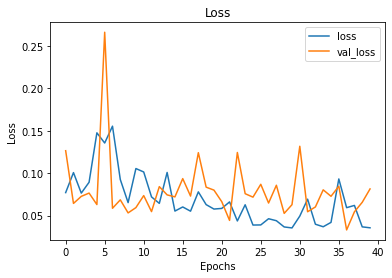

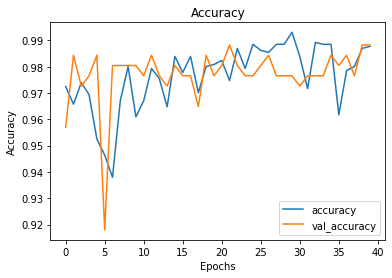

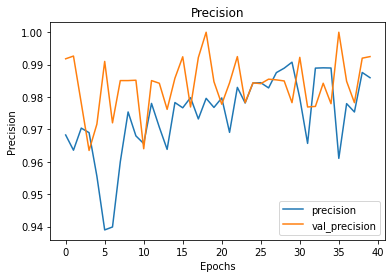

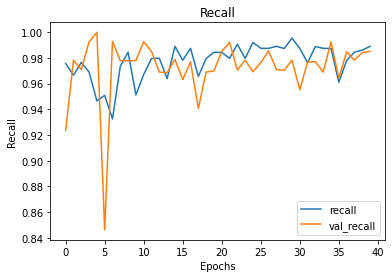

In [77]:
# Visualize Model Metrics
visualize_training_results(finetune_pretrain_model_history)

In [78]:
# Evaluate Model against Training set
finetune_pretrain_results_train = pretrain_model.evaluate(train_generator)
finetune_pretrain_results_train

22/22 [==============================] - 20s 903ms/step - loss: 0.0299 - accuracy: 0.9912 - precision: 0.9867 - recall: 0.9955


[0.0299490075558424,
 0.9912408590316772,
 0.9866864085197449,
 0.9955223798751831]

In [79]:
# Evaluate Model against Test set
finetune_pretrain_results_test = pretrain_model.evaluate(test_generator)
finetune_pretrain_results_test

5/5 [==============================] - 4s 840ms/step - loss: 0.2044 - accuracy: 0.9460 - precision: 0.9205 - recall: 0.9818


[0.2044191211462021,
 0.9460317492485046,
 0.9204545617103577,
 0.9818181991577148]

# EVALUATION

In [80]:
# Load saved model
mlp_original_model = keras.models.load_model('MLP_Initial_Model')

In [81]:
scores = mlp_original_model.evaluate(test_generator)
print("Loss of the model: %.2f%%"%(scores[0] * 100))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))
print("Test Precision: %.2f%%"%(scores[2] * 100))
print("Test Recall: %.2f%%"%(scores[3] * 100))

5/5 [==============================] - 3s 507ms/step - loss: 0.6769 - accuracy: 0.6317 - precision: 0.6099 - recall: 0.8242
Loss of the model: 67.69%
Test Accuracy: 63.17%
Test Precision: 60.99%
Test Recall: 82.42%


In [82]:
# Load saved model
mlp_finetune_model = keras.models.load_model('MLP_Finetune_Checkpoint')

In [83]:
# Finalized, Organized, Evaluate against Test set with metrics
scores = mlp_finetune_model.evaluate(test_generator)
print("Loss of the model: %.2f%%"%(scores[0] * 100))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))
print("Test Precision: %.2f%%"%(scores[2] * 100))
print("Test Recall: %.2f%%"%(scores[3] * 100))

5/5 [==============================] - 3s 486ms/step - loss: 0.4585 - accuracy: 0.8000 - precision: 0.8148 - recall: 0.8000
Loss of the model: 45.85%
Test Accuracy: 80.00%
Test Precision: 81.48%
Test Recall: 80.00%


In [84]:
# Load saved model
cnn_initial_model = keras.models.load_model('CNN_Initial_Model')

In [85]:
# Finalized, Organized, Evaluate against Test set with metrics
scores = cnn_initial_model.evaluate(test_generator)
print("Loss of the model: %.2f%%"%(scores[0] * 100))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))
print("Test Precision: %.2f%%"%(scores[2] * 100))
print("Test Recall: %.2f%%"%(scores[3] * 100))

5/5 [==============================] - 3s 507ms/step - loss: 0.2805 - accuracy: 0.9270 - precision: 0.9329 - recall: 0.9273
Loss of the model: 28.05%
Test Accuracy: 92.70%
Test Precision: 93.29%
Test Recall: 92.73%


In [86]:
# Load saved model
cnn_finetune_model = keras.models.load_model('CNN_Finetune_Checkpoint')

In [87]:
# Finalized, Organized, Evaluate against Test set with metrics
scores = cnn_finetune_model.evaluate(test_generator)
print("Loss of the model: %.2f%%"%(scores[0] * 100))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))
print("Test Precision: %.2f%%"%(scores[2] * 100))
print("Test Recall: %.2f%%"%(scores[3] * 100))

5/5 [==============================] - 3s 513ms/step - loss: 0.2811 - accuracy: 0.9397 - precision: 0.9620 - recall: 0.9212
Loss of the model: 28.11%
Test Accuracy: 93.97%
Test Precision: 96.20%
Test Recall: 92.12%


In [88]:
# Load saved model
pretrain_model = keras.models.load_model('Pretrain_Initial_Model')

In [89]:
# Finalized, Organized, Evaluate against Test set with metrics
scores = pretrain_model.evaluate(test_generator)
print("Loss of the model: %.2f%%"%(scores[0] * 100))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))
print("Test Precision: %.2f%%"%(scores[2] * 100))
print("Test Recall: %.2f%%"%(scores[3] * 100))

5/5 [==============================] - 5s 559ms/step - loss: 0.2691 - accuracy: 0.9302 - precision: 0.8865 - recall: 0.9939
Loss of the model: 26.91%
Test Accuracy: 93.02%
Test Precision: 88.65%
Test Recall: 99.39%


In [90]:
# Load saved model
pretrain_finetune_model = keras.models.load_model('Finetune_Pretrain_Checkpoint')

In [91]:
# Finalized, Organized, Evaluate against Test set with metrics
scores = pretrain_finetune_model.evaluate(test_generator)
print("Loss of the model: %.2f%%"%(scores[0] * 100))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))
print("Test Precision: %.2f%%"%(scores[2] * 100))
print("Test Recall: %.2f%%"%(scores[3] * 100))

5/5 [==============================] - 5s 554ms/step - loss: 0.2044 - accuracy: 0.9460 - precision: 0.9205 - recall: 0.9818
Loss of the model: 20.44%
Test Accuracy: 94.60%
Test Precision: 92.05%
Test Recall: 98.18%


In [92]:
# Notebook Stop, Total Time.
notebook_end = datetime.datetime.now()
notebook_elapsed = notebook_end - notebook_original_start
print('Notebook took a total of {}'.format(elapsed))

Notebook took a total of 0:24:13.168046


| Metrics           | Loss   | Accuracy | Precision | Recall |
|-------------------|--------|----------|-----------|--------|
| MLP Original      | 67.69% | 63.17%   | 60.99%    | 82.42% |
| MLP Finetune      | 45.85% | 80.00%   | 81.48%    | 80.00% |
| CNN Original      | 28.05% | 92.70%   | 93.29%    | 92.73% |
| CNN Finetune      | 28.11% | 93.97%   | 96.20%    | 92.12% |
| Pretrain Original | 26.91% | 93.02%   | 88.65%    | 99.39% |
| Pretrain Finetune | 20.44% | 94.60%   | 92.05%    | 98.18% |